### Importy

In [1]:
import os
os.getcwd()

'/content'

In [ ]:
pip install shap timeshap ta

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, InputLayer
from keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import shap
from scripts.train_utilities import *
from scripts.essentials import *
from scripts.plots import *
from keras.models import load_model

In [4]:
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
train_set = pd.read_csv('train_set_full.csv')
test_set = pd.read_csv('test_set_full.csv')
val_set = pd.read_csv('val_set_full.csv')

In [9]:
prefix = "BA"

### Funkcje

In [8]:
def create_unique_subsets(columns, subset_size=5, min_diff=2):
    """
    Create subsets of columns where each subset differs from every other subset by at least 'min_diff' columns.

    :param columns: List of all columns.
    :param subset_size: The size of each subset.
    :param min_diff: Minimum number of different columns between any two subsets.
    :return: A list of unique subsets.
    """
    all_combinations = list(itertools.combinations(columns, subset_size))
    unique_subsets = []

    for combo in all_combinations:
        if all(len(set(combo) - set(subset)) >= min_diff for subset in unique_subsets):
            unique_subsets.append(combo)

    return unique_subsets

def make_model_better(X, y, X_val, y_val, n_epochs, lstm_units=64, dense_units=10, patience=5):
    model = Sequential()
    model.add(InputLayer(input_shape=(X.shape[1], X.shape[2])))

    # LSTM layers
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(LSTM(units=lstm_units, return_sequences=False))

    # Dense layers
    model.add(Dense(units=dense_units))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Early stopping and model checkpoint
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

    # Train the model
    history = model.fit(X, y, epochs=n_epochs, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

    return model, history

# Example usage:
# model, history = make_model(X_train, y_train, X_val, y_val, n_epochs=50, lstm_units=64, dense_units=10, patience=5)

def window_dataset(df, target_column, window_size):
    X = []
    y = []

    # Iterate over the dataset
    for i in range(len(df) - window_size):
        # Extract the window of data
        window = df[i:i+window_size]

        # Extract the features (X) and target (y)
        X.append(window.drop(columns=[target_column]).values)
        y.append(df[target_column][i+window_size])

    return np.array(X), np.array(y)

def run_multiple_models(train_set,val_set,cols_subset,n_epochs=100):

  window_size = 10
  target_cols = ['target_5']
  mse_val = []
  mse_train = []
  aggregated_shap = []
  for idx,cols_used in enumerate(cols_subset):
    print('-------------------------------')
    print(idx)

    X,y = window_dataset(train_set[list(cols_used)+target_cols],  target_cols[0], window_size)
    X_val, y_val = window_dataset(val_set[list(cols_used)+target_cols], target_cols[0], window_size)

    model,history = make_model(X,y, X_val, y_val, n_epochs)

    mse_val.append(min(history.history['val_loss']))
    mse_train.append(min(history.history['loss']))

    explainer = shap.DeepExplainer(model, X)
    shap_values = explainer.shap_values(X_val)

    aggregated_shap.append(np.mean(np.abs(shap_values[0]), axis=0))

    #create df
    if (idx%15 == 0):
      df = pd.DataFrame({'cols_used': cols_subset[:idx+1], 'mse_val': mse_val, 'mse_train': mse_train,
                        'aggregated_shap':aggregated_shap})
      df.to_csv('df_shap'+str(idx))
  df = pd.DataFrame({'cols_used': cols_subset, 'mse_val': mse_val, 'mse_train': mse_train,
                        'aggregated_shap':aggregated_shap})
  df.to_csv('df_shap_final')

  return df

def parse_cols_used(cols_string):
    """
    Parses the column names used in the model from the string representation.

    Args:
    cols_string (str): A string representing the tuple of column names.

    Returns:
    list: A list of column names.
    """
    # Remove the outer brackets and split the string into column names
    cols = cols_string.strip("()").split(", ")
    # Remove quotes and extra characters from column names
    cleaned_cols = [col.strip("'") for col in cols]
    return cleaned_cols

def parse_shap_values(shap_string):
    """
    Parses a string representation of a list of lists of SHAP values into a Python list of lists.

    Args:
    shap_string (str): A string representing a list of lists of SHAP values.

    Returns:
    list of lists: A list of lists of SHAP values.
    """
    # Remove the outer brackets and split the string into rows, handling newline characters
    rows = shap_string.strip('[]').split('\n')

    # Parse each row into a list of floats
    parsed_rows = [list(map(float, row.strip(' []').split())) for row in rows]

    return parsed_rows

def make_model(X, y, X_val, y_val, n_epochs, lstm_units=32,dense_units=8):
    tf.keras.backend.clear_session()

    model = Sequential()
    model.add(InputLayer(input_shape=(X.shape[1], X.shape[2])))

    # LSTM layers
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(LSTM(units=lstm_units, return_sequences=False))

    # Dense layers
    model.add(Dense(units=dense_units))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Early stopping and model checkpoint

    # Train the model
    history = model.fit(X, y, epochs=n_epochs, validation_data=(X_val, y_val),
                        verbose=0)

    return model, history

def plot_mean_feature_importance(shap_values, feature_names,max_=False):
    """
    Plot the mean importance of each feature across all time steps.

    :param shap_values: A 3D array of SHAP values with shape (samples, window_size, num_features).
    :param feature_names: List of feature names.
    """
    if max_:
    # Aggregate SHAP values across all samples and time steps
      aggregated_shap = np.max(np.abs(shap_values), axis=(0))
    else:
      aggregated_shap = np.mean(np.abs(shap_values), axis=(0))


    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, aggregated_shap)
    plt.title('Mean Feature Importance Across All Time Steps')
    plt.ylabel('Mean SHAP Value')
    plt.xlabel('Features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Zmienne

Newsy

In [6]:
train_set.columns

Index(['future', 'influential', 'trustworthy', 'not clickbait',
       'finbert_Score', 'bart_Score', 'vader_Score', 'future_finbert',
       'future_bart', 'future_vader', 'influential_finbert',
       'influential_bart', 'influential_vader', 'trustworthy_finbert',
       'trustworthy_bart', 'trustworthy_vader', 'clickbait_finbert',
       'clickbait_bart', 'clickbait_vader', 'Date', '^GSPC_Close',
       'EURUSD=X_Close', 'BA_Open', 'BA_High', 'BA_Low', 'BA_Close',
       'mean_future', 'mean_influential', 'mean_trustworthy', 'mean_clickbait',
       'norm_rsi_14', 'norm_rsi_gspc_14', 'norm_slowk_14', 'vwap_14',
       'norm_roc_14', 'log_return_1', 'log_return_5', 'log_return_10',
       'log_return_20', 'log_return_gspc_1', 'log_return_gspc_5',
       'log_return_gspc_10', 'log_return_gspc_20', 'target_1', 'target_5',
       'target_10', 'target_20', 'minmax_^GSPC_Volume', 'minmax_BA_Volume',
       'minmax_daily_variation', 'minmax_high_close_pressure',
       'minmax_low_open_pre

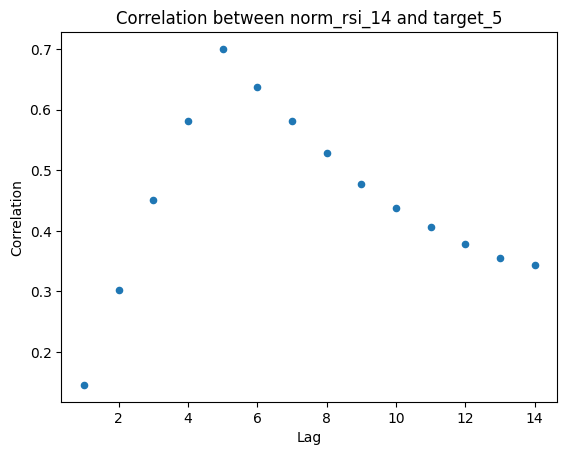

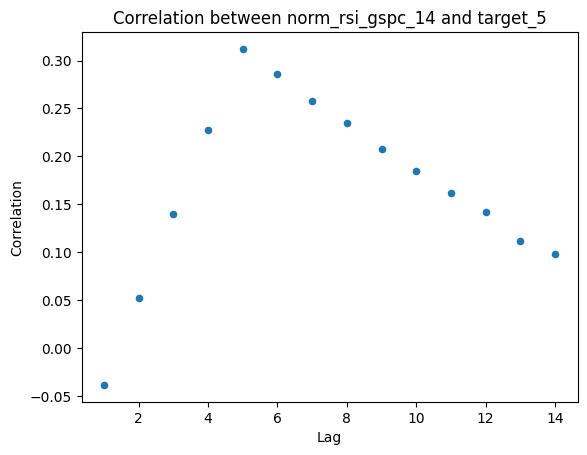

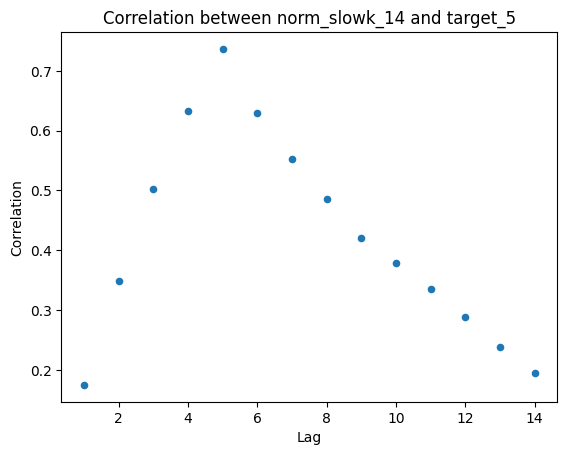

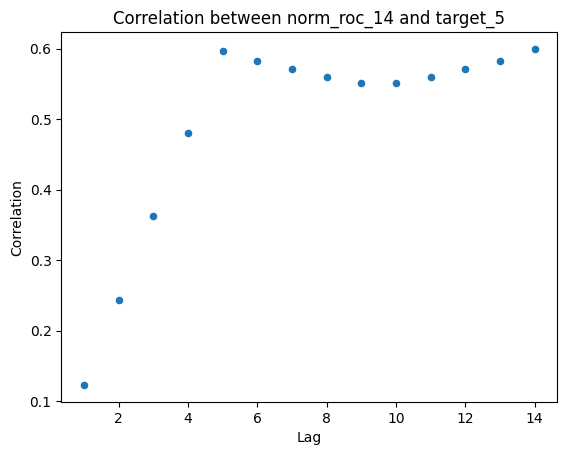

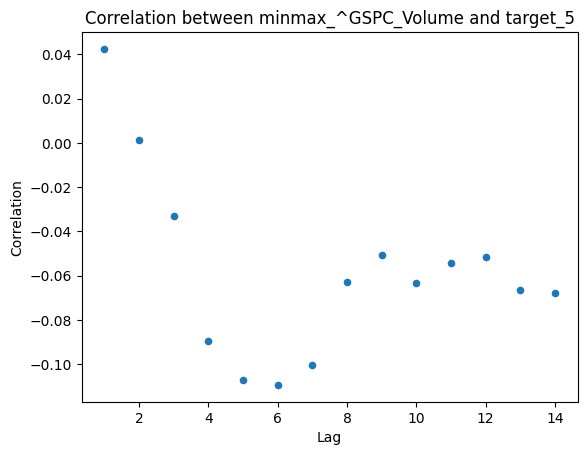

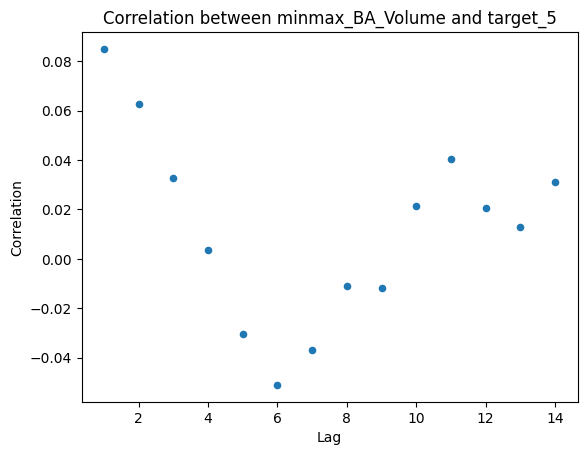

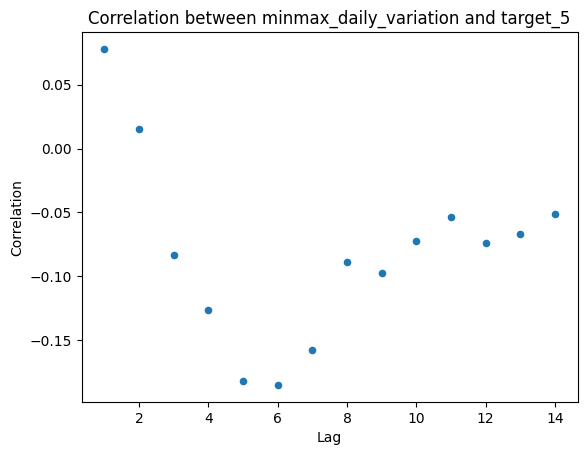

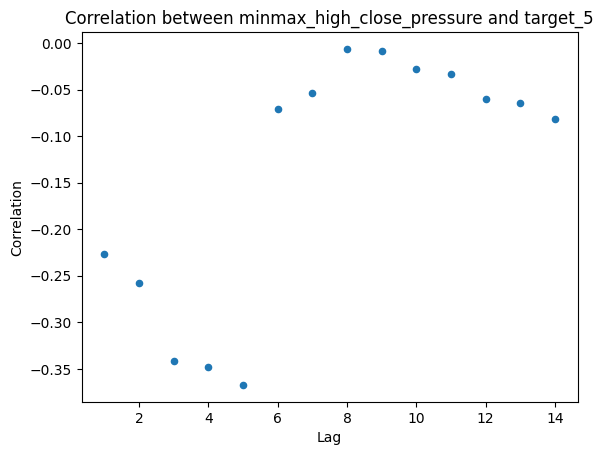

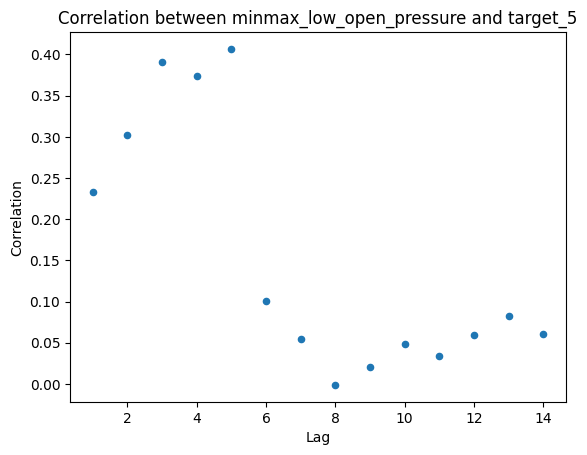

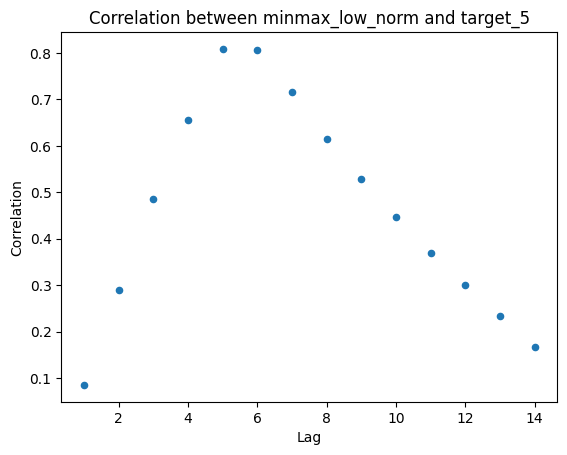

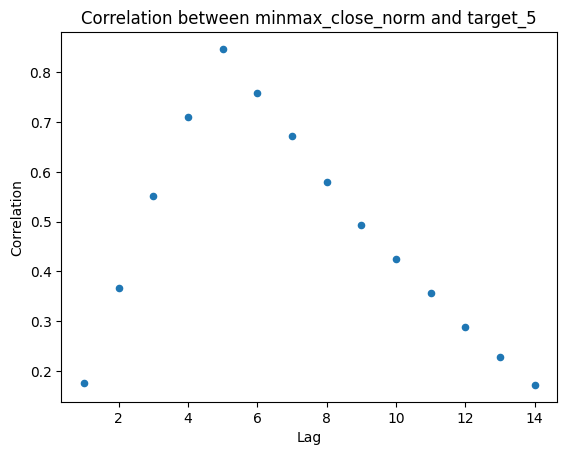

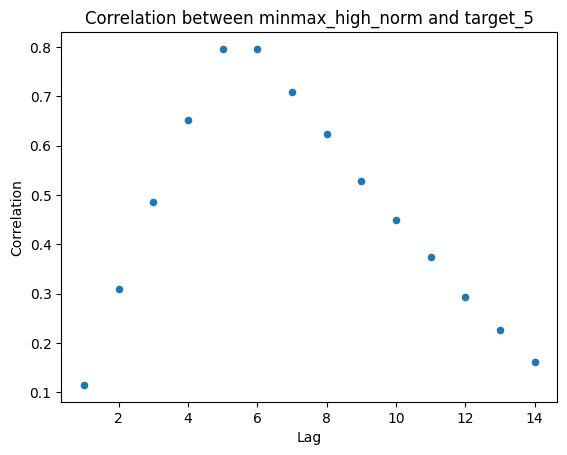

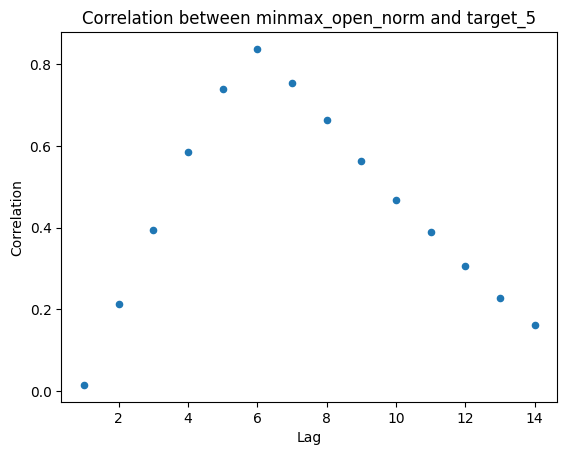

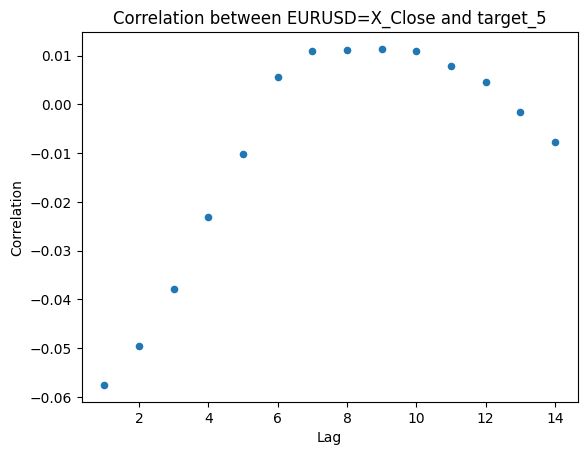

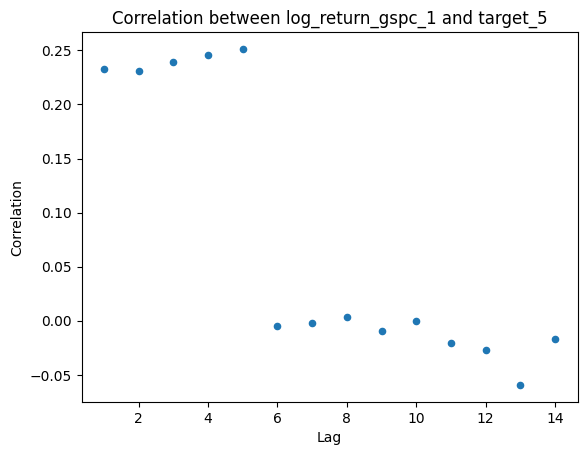

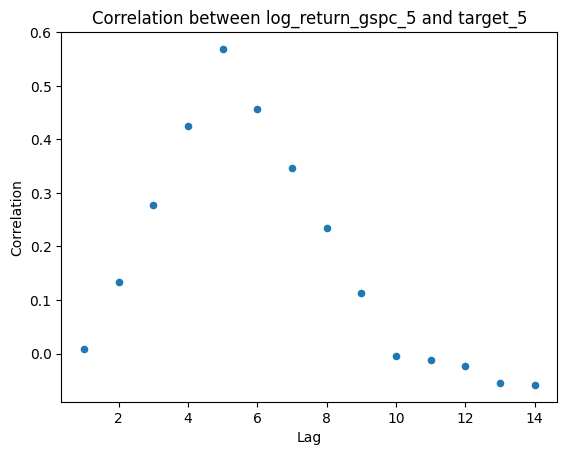

In [10]:
plot_lagged_correlations(train_set[['norm_rsi_14', 'norm_rsi_gspc_14', 'norm_slowk_14', 'norm_roc_14',
        'minmax_^GSPC_Volume', 'minmax_BA_Volume', 'minmax_daily_variation',
       'minmax_high_close_pressure', 'minmax_low_open_pressure',
       'minmax_low_norm', 'minmax_close_norm', 'minmax_high_norm',
       'minmax_open_norm', 'EURUSD=X_Close', 'log_return_gspc_1' ,'log_return_gspc_5','target_5']], 'target_5')

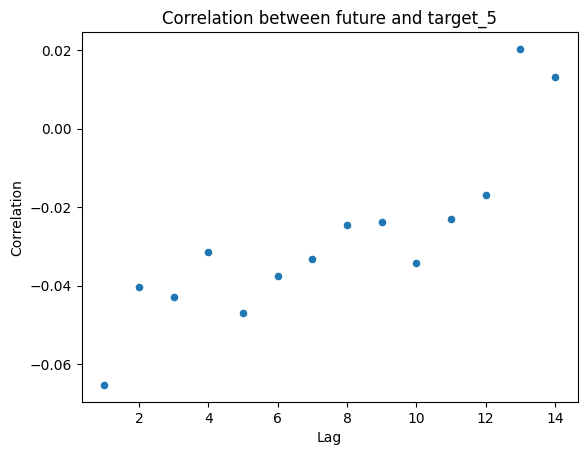

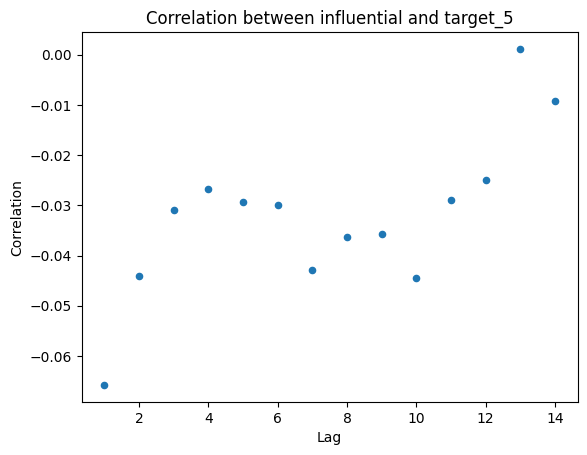

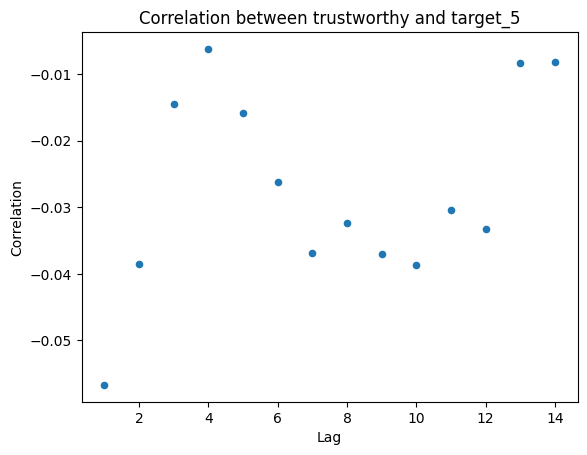

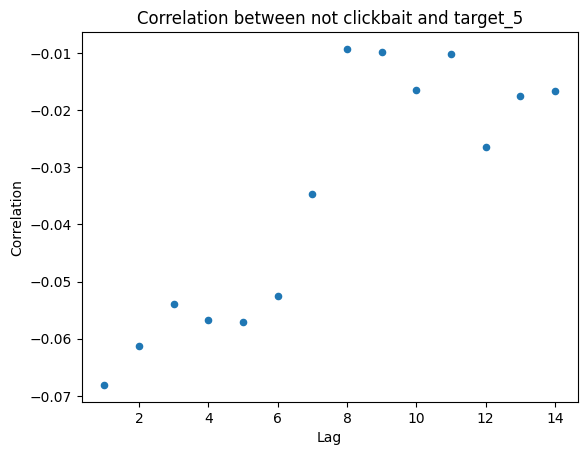

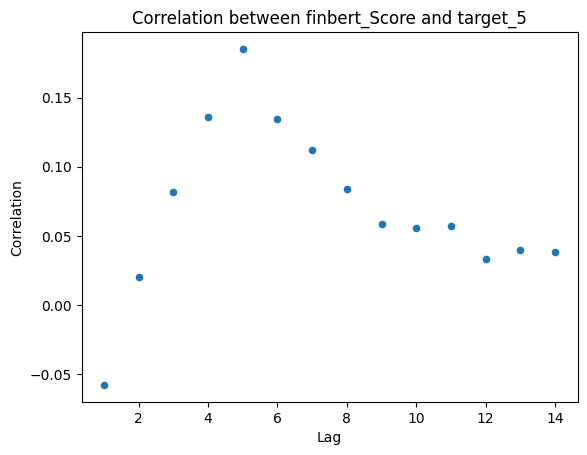

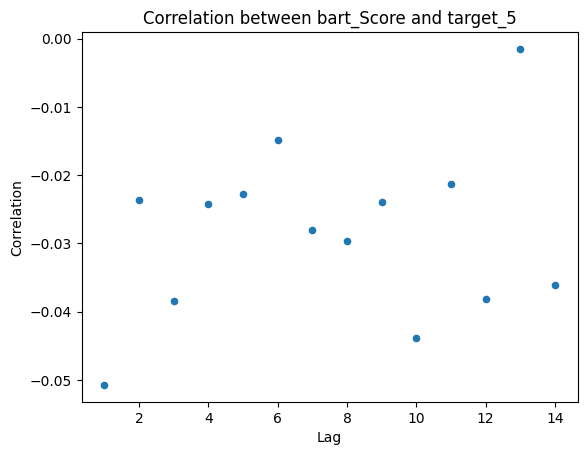

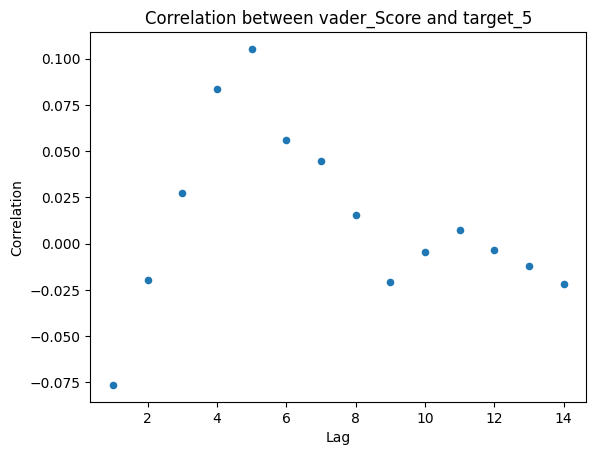

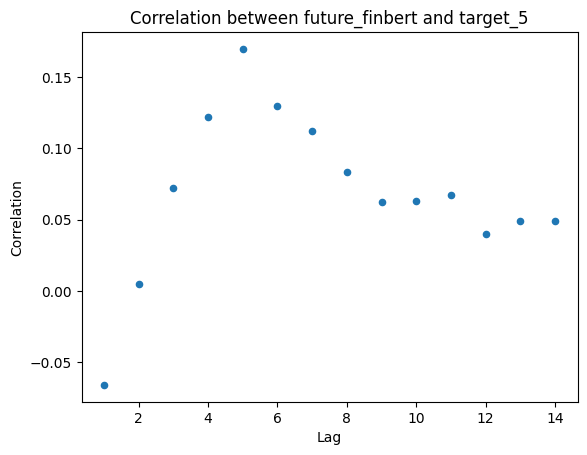

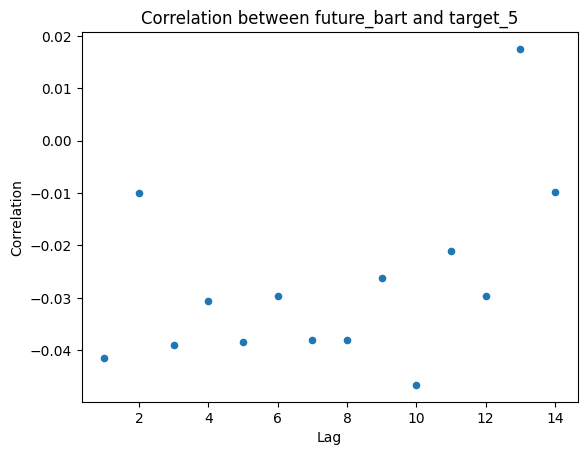

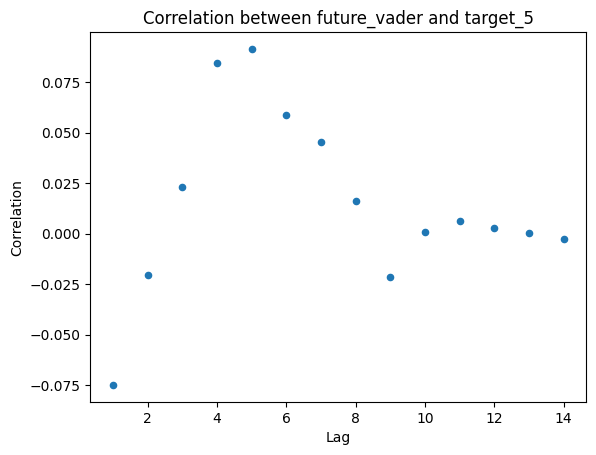

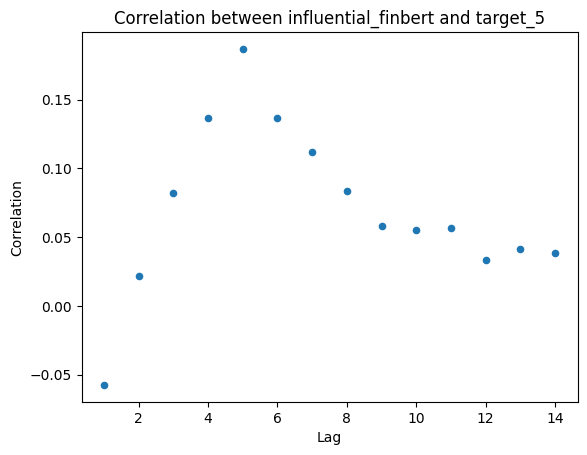

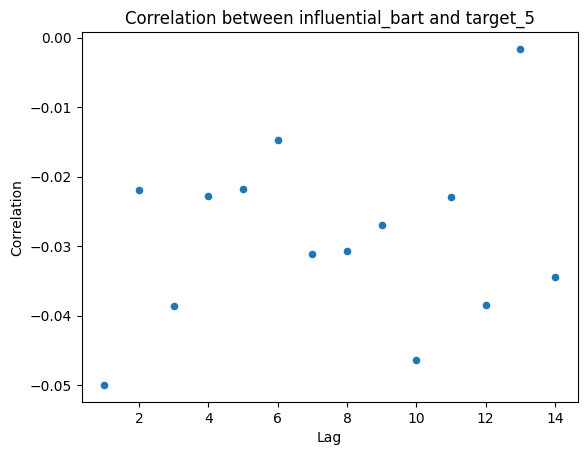

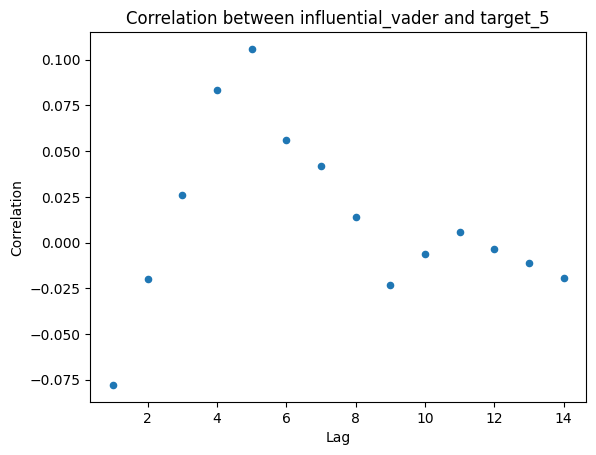

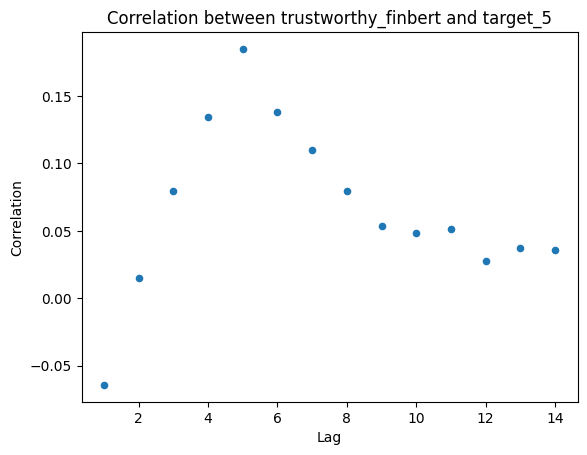

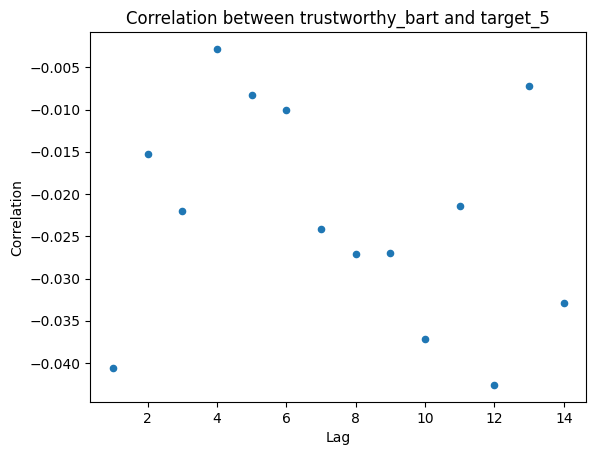

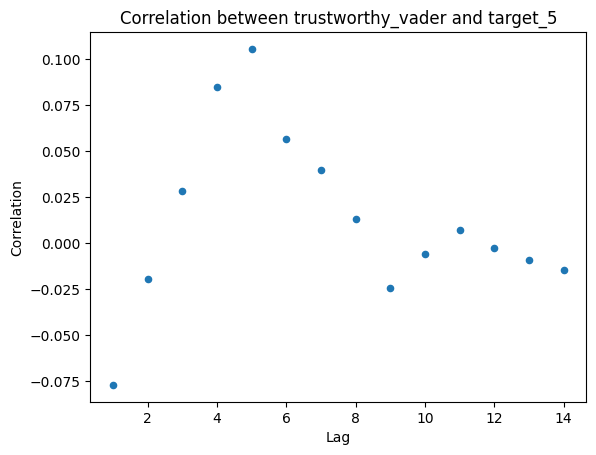

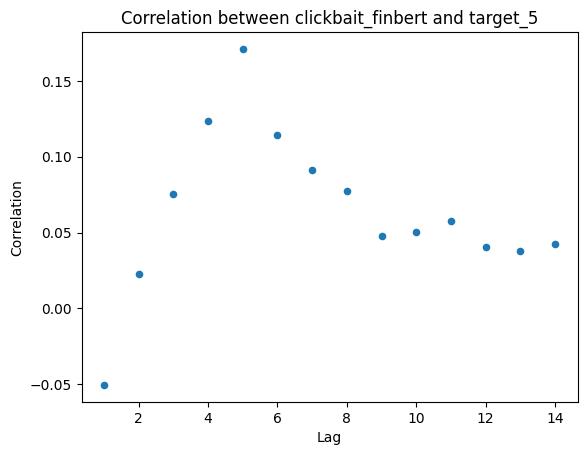

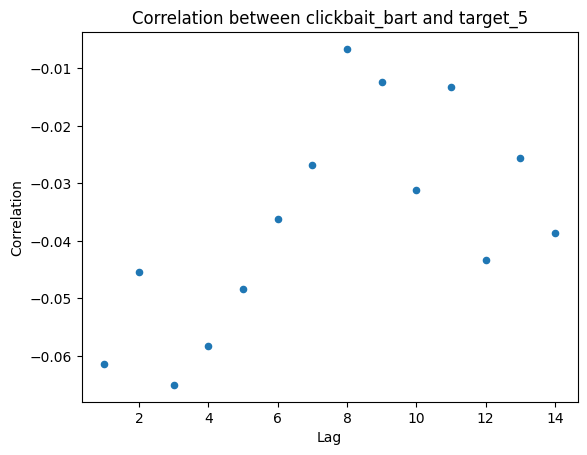

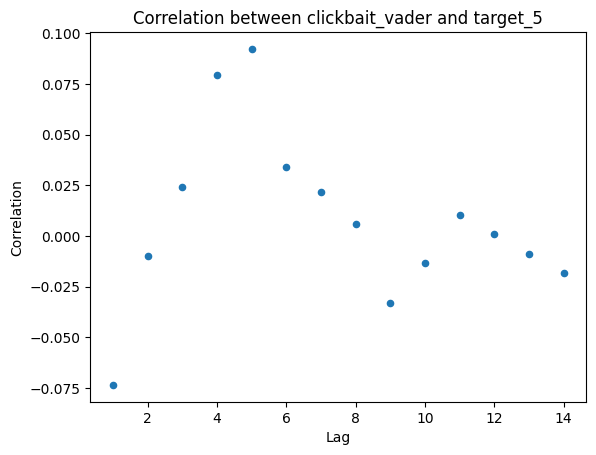

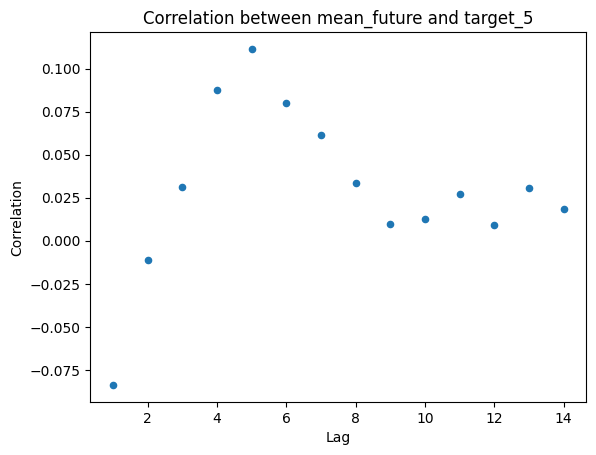

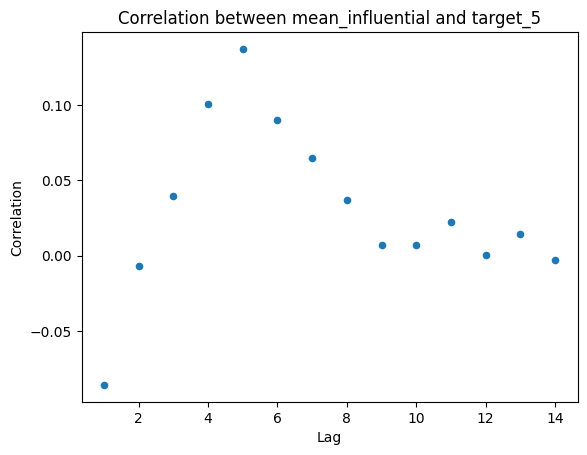

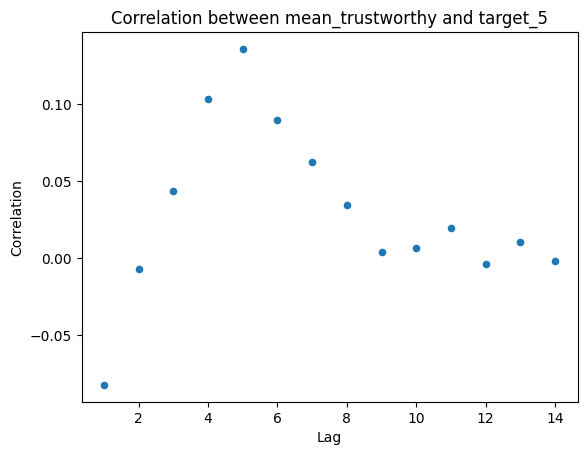

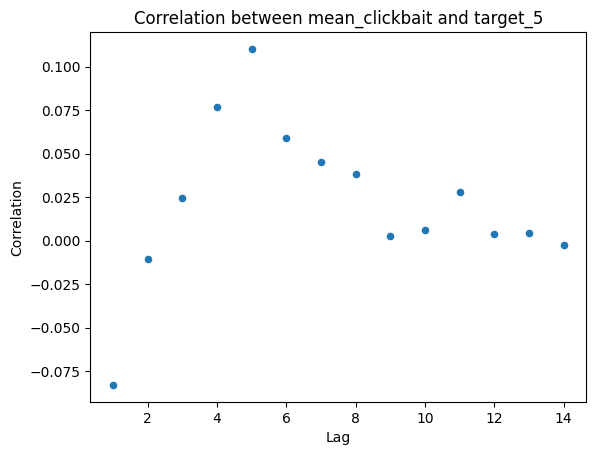

In [11]:
plot_lagged_correlations(train_set[['future', 'influential', 'trustworthy', 'not clickbait',
       'finbert_Score', 'bart_Score', 'vader_Score', 'future_finbert',
       'future_bart', 'future_vader', 'influential_finbert',
       'influential_bart', 'influential_vader', 'trustworthy_finbert',
       'trustworthy_bart', 'trustworthy_vader', 'clickbait_finbert',
       'clickbait_bart', 'clickbait_vader','mean_future', 'mean_influential', 'mean_trustworthy', 'mean_clickbait','target_5']], 'target_5')

### Shap dla prostych LSTM - szukanie globalnej wagi kolumn

In [9]:
cols = ['finbert_Score', 'bart_Score', 'vader_Score',
        'mean_future', 'mean_influential', 'mean_trustworthy', 'mean_clickbait',
        'norm_rsi_14', 'norm_rsi_gspc_14',
        'norm_slowk_14', 'norm_roc_14',
        'minmax_BA_Volume','log_return_5','log_return_1','EURUSD=X_Close',
        'minmax_daily_variation', 'minmax_high_close_pressure',
        'minmax_low_open_pressure',
        'minmax_low_norm', 'minmax_close_norm',
        'minmax_high_norm', 'minmax_open_norm']

u = create_unique_subsets(cols, subset_size=5, min_diff=3)

In [10]:
shift_ = 5
window_size = 10
target_cols = ['target_5']
y_base_val = val_set[target_cols[0]].shift(shift_)[window_size:].values
y_base_train = train_set[target_cols[0]].shift(shift_)[window_size:].values
y_base0_val = [0 for i in range((val_set.shape[0]-window_size))]
y_base0_train = [0 for i in range((train_set.shape[0]-window_size))]

In [11]:
len(u)

97

In [15]:
df = run_multiple_models(train_set,val_set,u,n_epochs=200)

-------------------------------
0


-------------------------------
1


-------------------------------
2


-------------------------------
3


-------------------------------
4


-------------------------------
5


-------------------------------
6


-------------------------------
7


-------------------------------
8


-------------------------------
9


-------------------------------
10


-------------------------------
11


-------------------------------
12


-------------------------------
13


-------------------------------
14


-------------------------------
15


-------------------------------
16


-------------------------------
17


-------------------------------
18


-------------------------------
19


-------------------------------
20


-------------------------------
21


-------------------------------
22


-------------------------------
23
-------------------------------
24


-------------------------------
25


-------------------------------
26


-------------------------------
27


-------------------------------
28


-------------------------------
29


-------------------------------
30


-------------------------------
31


-------------------------------
32


-------------------------------
33


-------------------------------
34


-------------------------------
35


-------------------------------
36


-------------------------------
37


-------------------------------
38


-------------------------------
39


-------------------------------
40


-------------------------------
41


-------------------------------
42


-------------------------------
43


-------------------------------
44


-------------------------------
45


-------------------------------
46


-------------------------------
47


-------------------------------
48


-------------------------------
49


-------------------------------
50


-------------------------------
51


-------------------------------
52


-------------------------------
53


-------------------------------
54


-------------------------------
55


-------------------------------
56


-------------------------------
57


-------------------------------
58


-------------------------------
59


-------------------------------
60


-------------------------------
61


-------------------------------
62


-------------------------------
63


-------------------------------
64


-------------------------------
65


-------------------------------
66


-------------------------------
67


-------------------------------
68


-------------------------------
69


-------------------------------
70


-------------------------------
71


-------------------------------
72


-------------------------------
73


-------------------------------
74


-------------------------------
75


-------------------------------
76


-------------------------------
77


-------------------------------
78


-------------------------------
79


-------------------------------
80


-------------------------------
81


-------------------------------
82


-------------------------------
83


-------------------------------
84


-------------------------------
85


-------------------------------
86


-------------------------------
87


-------------------------------
88


-------------------------------
89


-------------------------------
90


-------------------------------
91


-------------------------------
92


-------------------------------
93


-------------------------------
94


-------------------------------
95


-------------------------------
96


In [16]:
df.to_csv("df_BA_shap.csv")

In [13]:
# df = pd.read_csv("df_shap_final")
# df['cols_used'] = df['cols_used'].apply(parse_cols_used)
# df['aggregated_shap'] = df['aggregated_shap'].apply(parse_shap_values)

top_10_df = df.nsmallest(10, 'mse_val')

In [22]:
top_10_df

,Unnamed: 0,cols_used,mse_val,mse_train,aggregated_shap
44,44,"[bart_Score, norm_rsi_14, log_return_5, minmax...",0.000896,0.001637,"[[0.00184334, 0.001898, 0.00056095, 0.00069737..."
24,24,"[finbert_Score, norm_rsi_14, norm_slowk_14, EU...",0.000970,0.001247,"[[0.00178253, 0.00254337, 0.00614147, 0.000205..."
6,6,"[finbert_Score, vader_Score, mean_trustworthy,...",0.000979,0.001118,"[[0.00496187, 0.00399872, 0.0038806, 0.0037360..."
43,43,"[bart_Score, norm_rsi_14, norm_rsi_gspc_14, mi...",0.000982,0.001148,"[[0.00632806, 0.00380524, 0.00244517, 0.003964..."
35,35,"[bart_Score, mean_influential, mean_trustworth...",0.000998,0.001649,"[[0.0031651, 0.00721756, 0.0115292, 0.0020546,..."
37,37,"[bart_Score, mean_influential, norm_rsi_14, no...",0.001010,0.001106,"[[0.00303479, 0.00272496, 0.00744301, 0.008473..."
4,4,"[finbert_Score, bart_Score, EURUSD=X_Close, mi...",0.001012,0.001503,"[[0.00151562844, 0.00288658218, 0.000121607885..."
33,33,"[bart_Score, mean_future, log_return_1, minmax...",0.001024,0.001413,"[[0.00329247, 0.0015783, 0.00114767, 0.0018132..."
77,77,"[mean_trustworthy, mean_clickbait, minmax_dail...",0.001036,0.001202,"[[0.00196569, 0.00251931, 0.00231082, 0.001371..."
45,45,"[bart_Score, norm_roc_14, minmax_BA_Volume, mi...",0.001074,0.001856,"[[0.0020525, 0.00079285, 0.00286484, 0.0031448..."


In [18]:
column_importance_sum_count = {}

for index, row in top_10_df.iterrows():
    shap_values = row['aggregated_shap']
    cols = row['cols_used']
    mean_shap = np.mean(shap_values, axis=0)

    # Update the sum and count of mean SHAP values for each column
    for col, value in zip(cols, mean_shap):
        if col in column_importance_sum_count:
            column_importance_sum_count[col]['sum'] += value
            column_importance_sum_count[col]['count'] += 1
        else:
            column_importance_sum_count[col] = {'sum': value, 'count': 1}

# Calculate the mean importance for each column
column_importance_mean = {col: (val['sum'] / val['count'] , val['count']) for col, val in column_importance_sum_count.items()}

# Sort the column importance dictionary for better readability
sorted_column_importance_mean = dict(sorted(column_importance_mean.items(), key=lambda item: item[1], reverse=True))

sorted_column_importance_mean

{'mean_influential': (0.0069647545, 2),
 'vader_Score': (0.006151192, 1),
 'mean_trustworthy': (0.005497249999999999, 3),
 'norm_slowk_14': (0.003821961999999999, 2),
 'minmax_open_norm': (0.0027545899999999995, 2),
 'bart_Score': (0.0026845468727142857, 7),
 'minmax_BA_Volume': (0.0023795113333333335, 3),
 'norm_rsi_gspc_14': (0.0022088505, 2),
 'finbert_Score': (0.0021158314740000006, 3),
 'minmax_low_norm': (0.002056984, 3),
 'minmax_daily_variation': (0.0020565819499999997, 5),
 'minmax_high_norm': (0.0020123199999999997, 1),
 'mean_clickbait': (0.002009077, 1),
 'log_return_1': (0.0017075395000000003, 2),
 'norm_rsi_14': (0.0017029270000000001, 4),
 'mean_future': (0.0014067840000000001, 1),
 'norm_roc_14': (0.0009537300000000001, 1),
 'minmax_low_open_pressure': (0.0008686176666666667, 3),
 'log_return_5': (0.0006104670000000001, 1),
 'EURUSD=X_Close': (0.000109224697125, 2),
 'minmax_high_close_pressure': (7.05401325e-05, 1)}

In [20]:
column_importance_sum_count = {}

for index, row in top_10_df.iterrows():
    shap_values = row['aggregated_shap']
    cols = row['cols_used']
    mean_shap = np.max(shap_values, axis=0)

    # Update the sum and count of mean SHAP values for each column
    for col, value in zip(cols, mean_shap):
        if col in column_importance_sum_count:
            column_importance_sum_count[col]['sum'] += value
            column_importance_sum_count[col]['count'] += 1
        else:
            column_importance_sum_count[col] = {'sum': value, 'count': 1}

# Calculate the mean importance for each column
column_importance_mean = {col: (val['sum'] / val['count'] , val['count']) for col, val in column_importance_sum_count.items()}

# Sort the column importance dictionary for better readability
sorted_column_importance_mean = dict(sorted(column_importance_mean.items(), key=lambda item: item[1], reverse=True))

sorted_column_importance_mean

{'mean_influential': (0.01246783, 2),
 'mean_trustworthy': (0.008722383333333335, 3),
 'vader_Score': (0.00859614, 1),
 'norm_slowk_14': (0.007307725, 2),
 'finbert_Score': (0.004625113366666667, 3),
 'bart_Score': (0.00398654840342857, 7),
 'norm_rsi_14': (0.003922405, 4),
 'minmax_BA_Volume': (0.0037147900000000004, 3),
 'minmax_open_norm': (0.00363986, 2),
 'mean_clickbait': (0.00346068, 1),
 'minmax_daily_variation': (0.0033551848719999998, 5),
 'norm_rsi_gspc_14': (0.00318714, 2),
 'minmax_high_norm': (0.00317973, 1),
 'mean_future': (0.00268053, 1),
 'log_return_1': (0.00254144, 2),
 'minmax_low_norm': (0.0025056633333333336, 3),
 'norm_roc_14': (0.00155015, 1),
 'minmax_low_open_pressure': (0.0013862266666666665, 3),
 'log_return_5': (0.00137417, 1),
 'EURUSD=X_Close': (0.000241295067, 2)}

### TOP 10 modeli SHAP


44


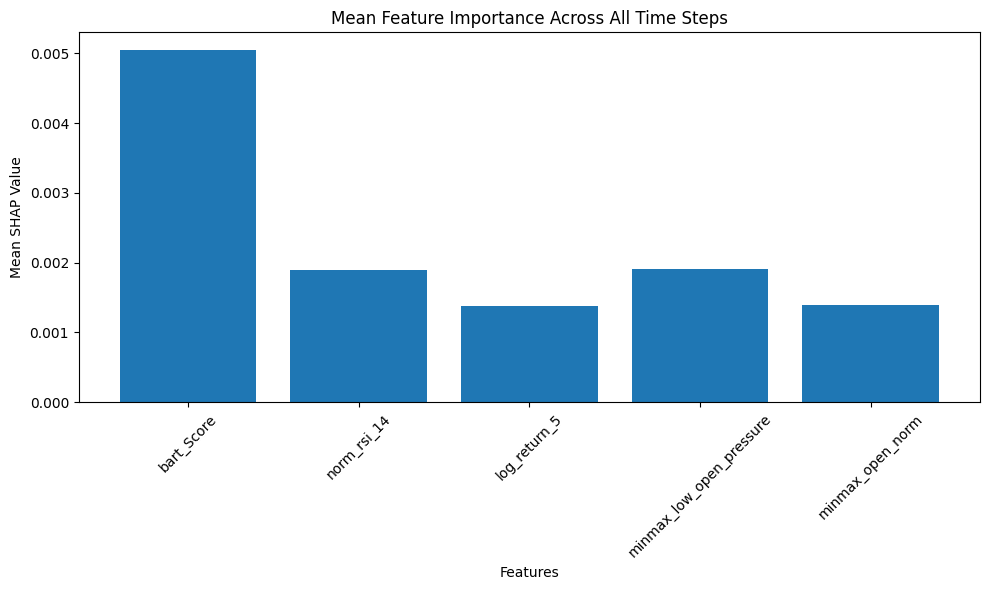

24


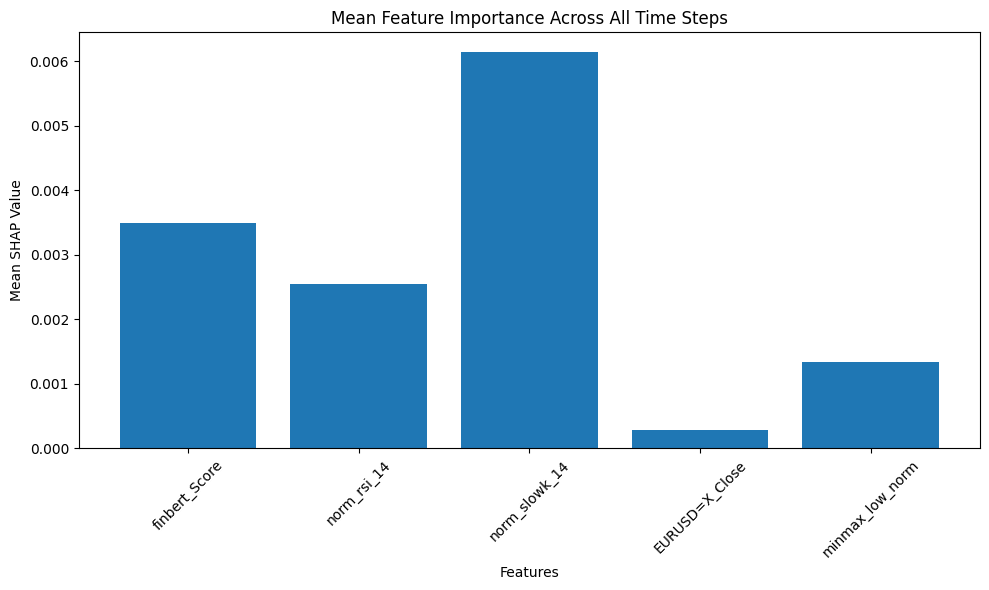

6


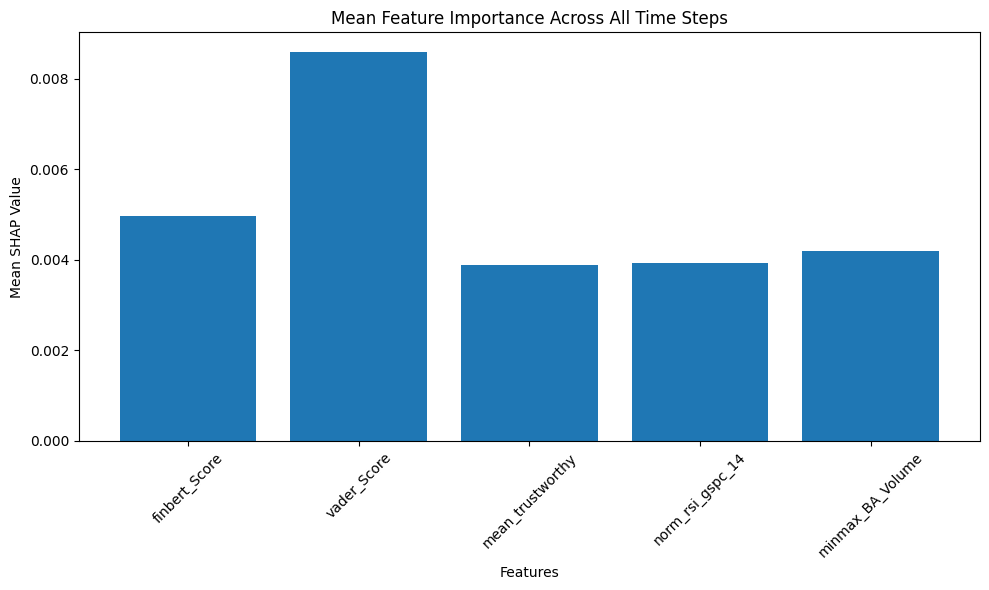

43


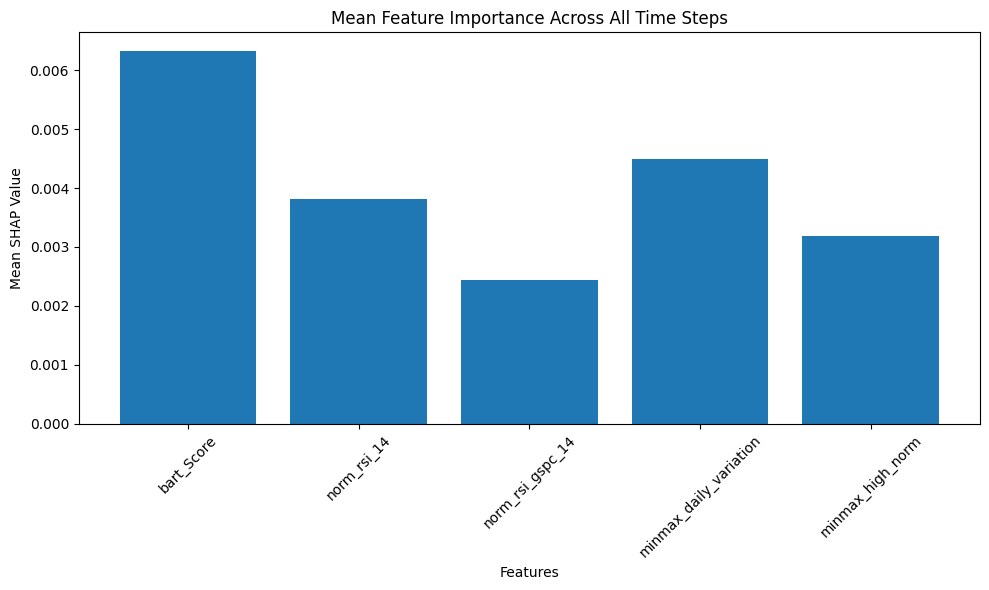

35


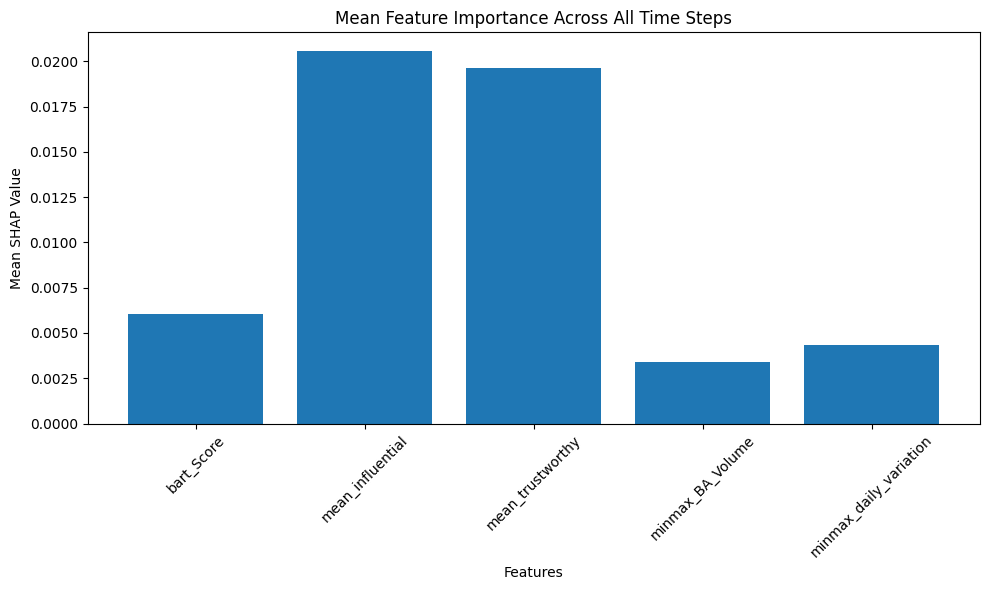

37


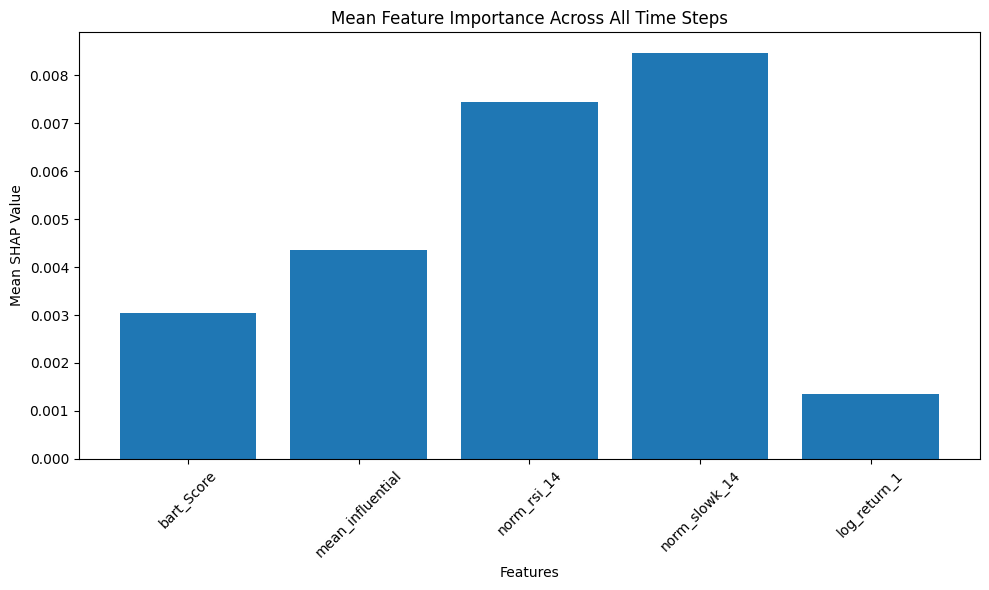

4


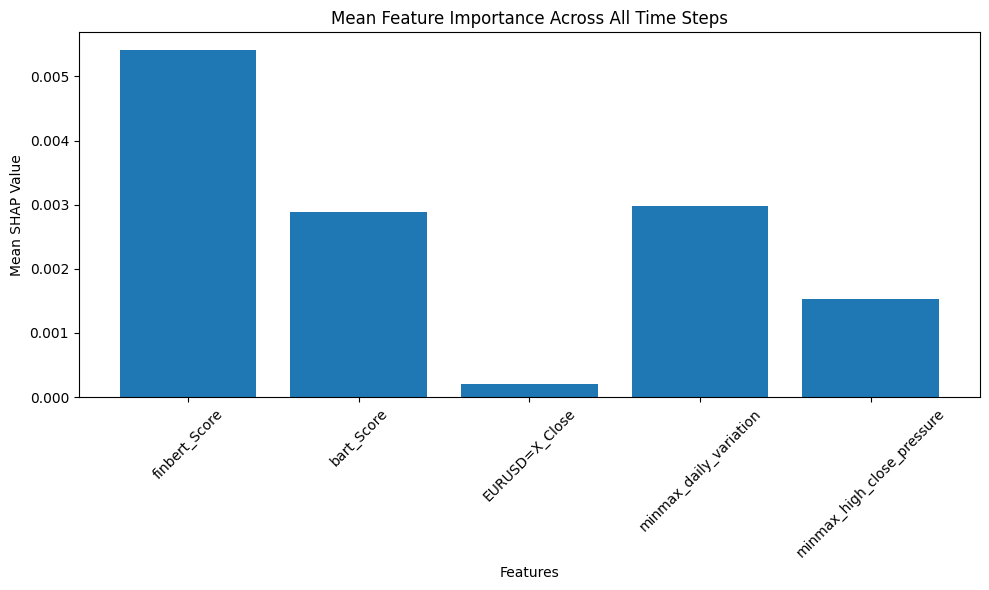

33


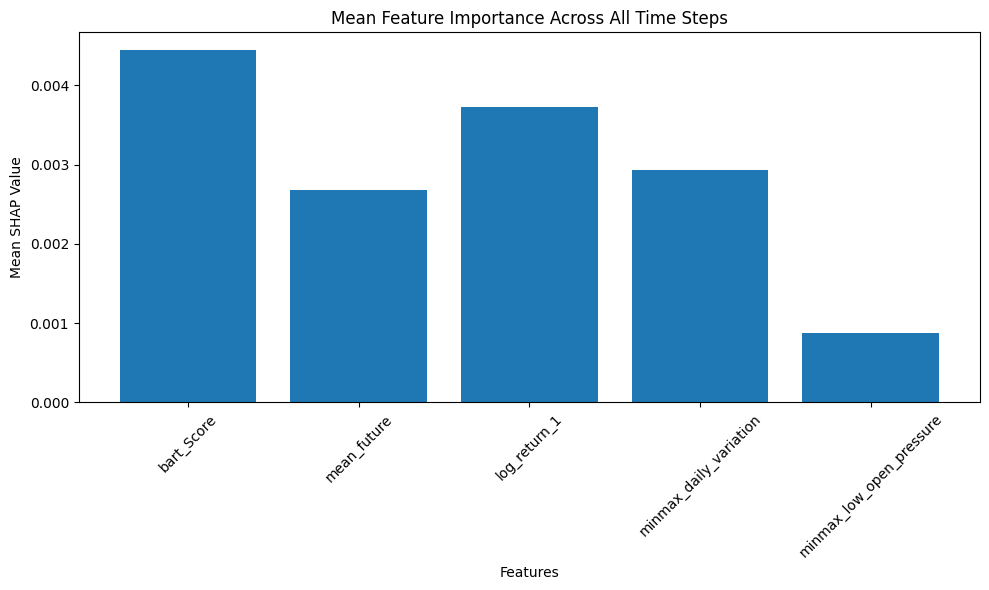

77


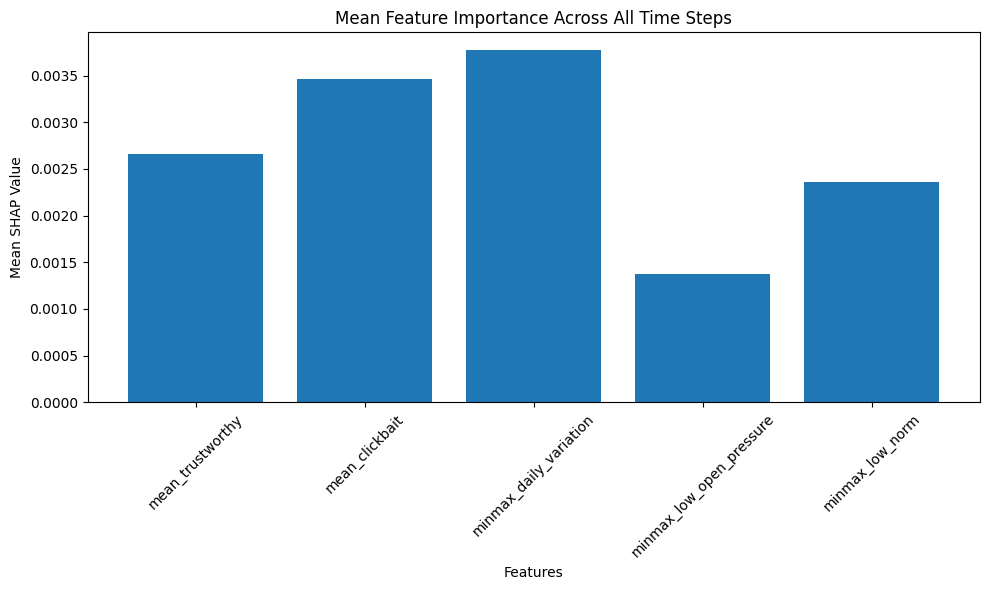

45


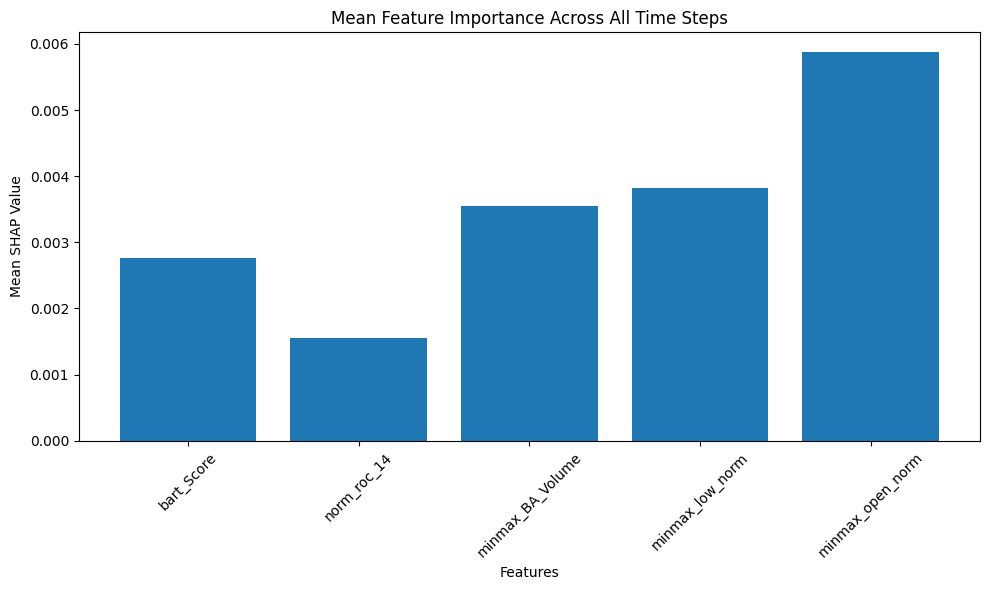

In [44]:
#max across windows
for index, row in top_10_df.iterrows():
    print(index)
    shap_values = row['aggregated_shap']
    feature_names = row['cols_used']
    plot_mean_feature_importance(shap_values, feature_names,True)

44


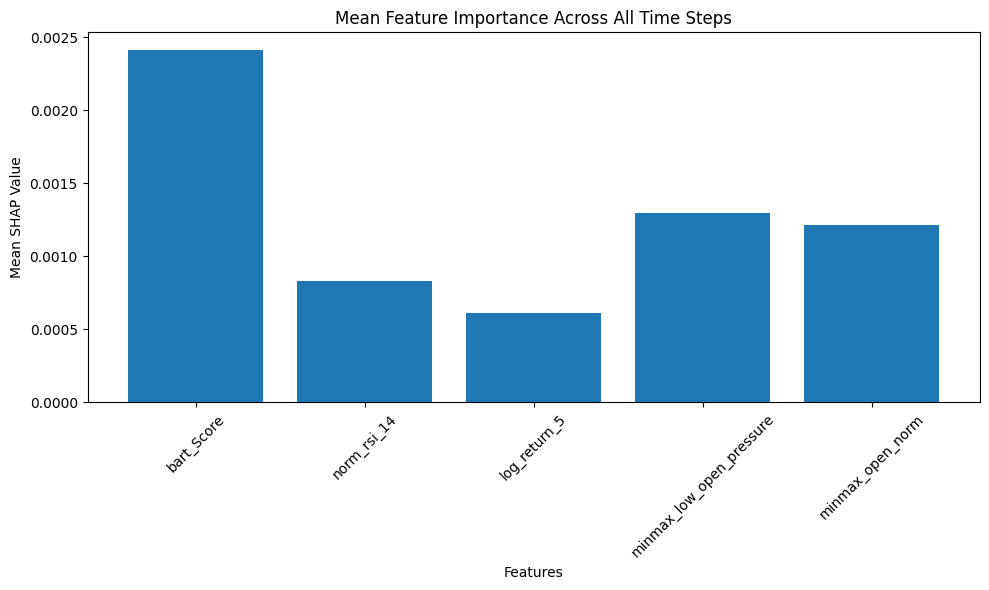

24


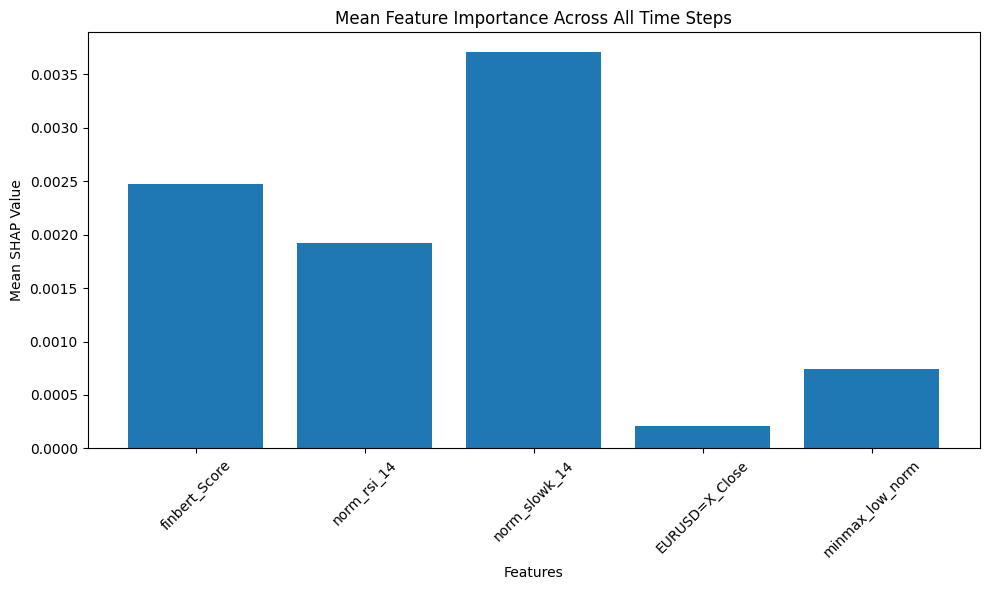

6


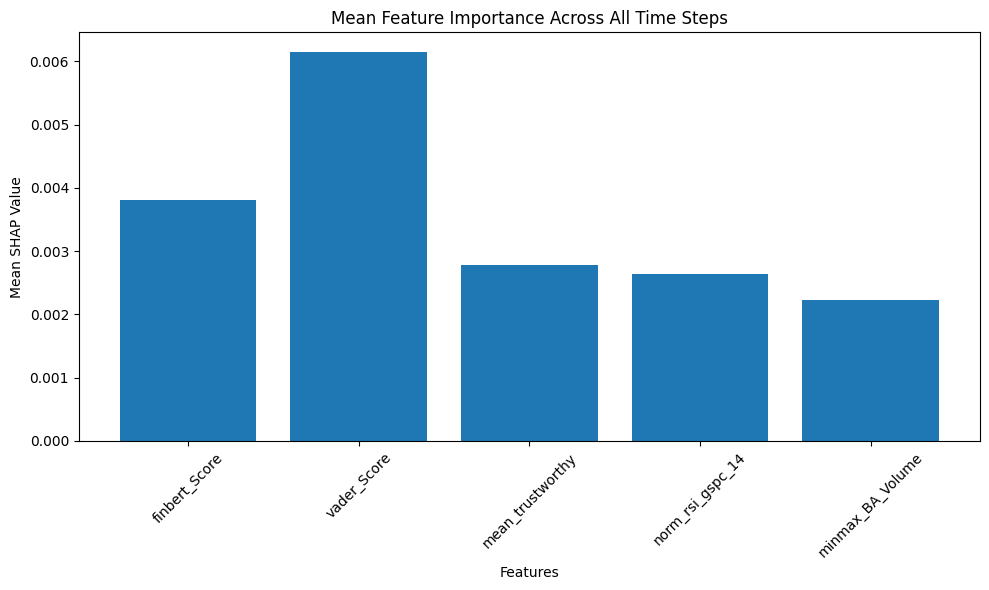

43


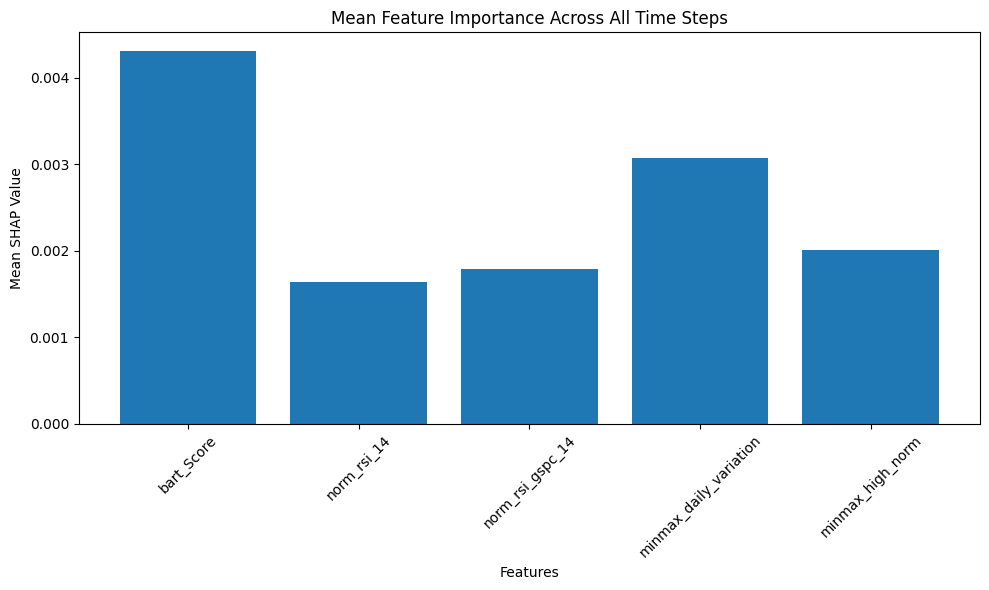

35


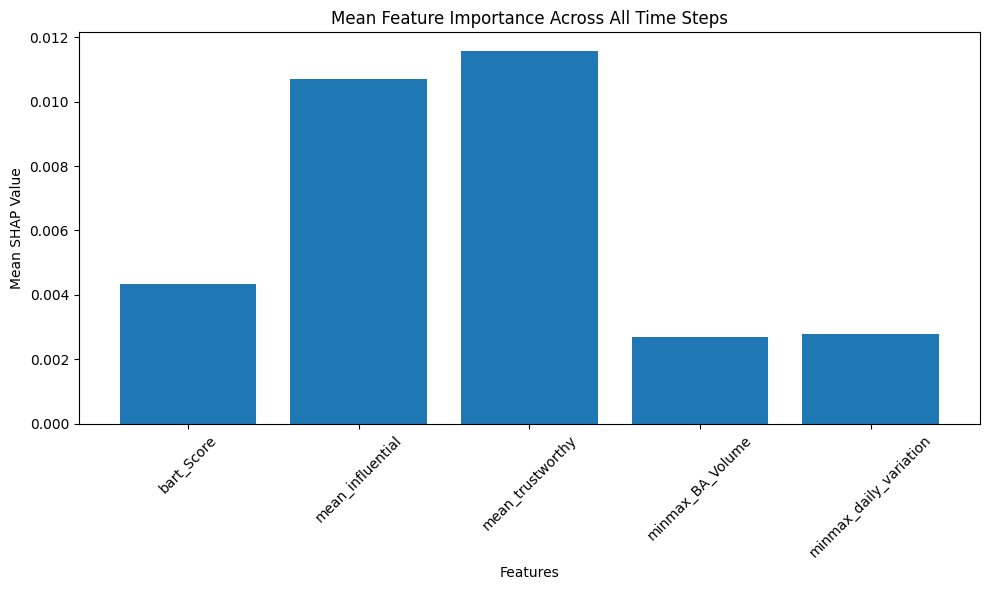

37


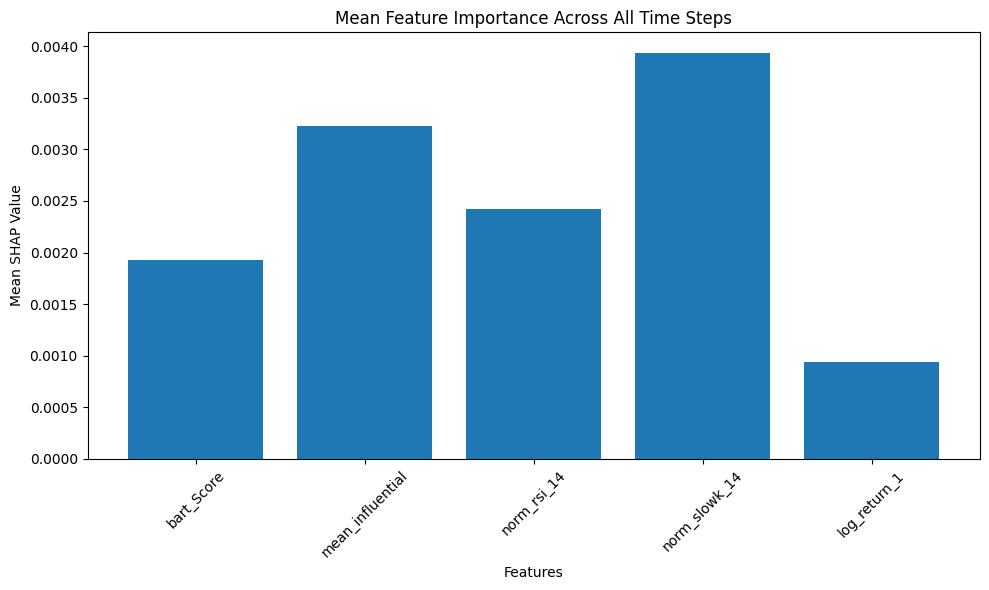

4


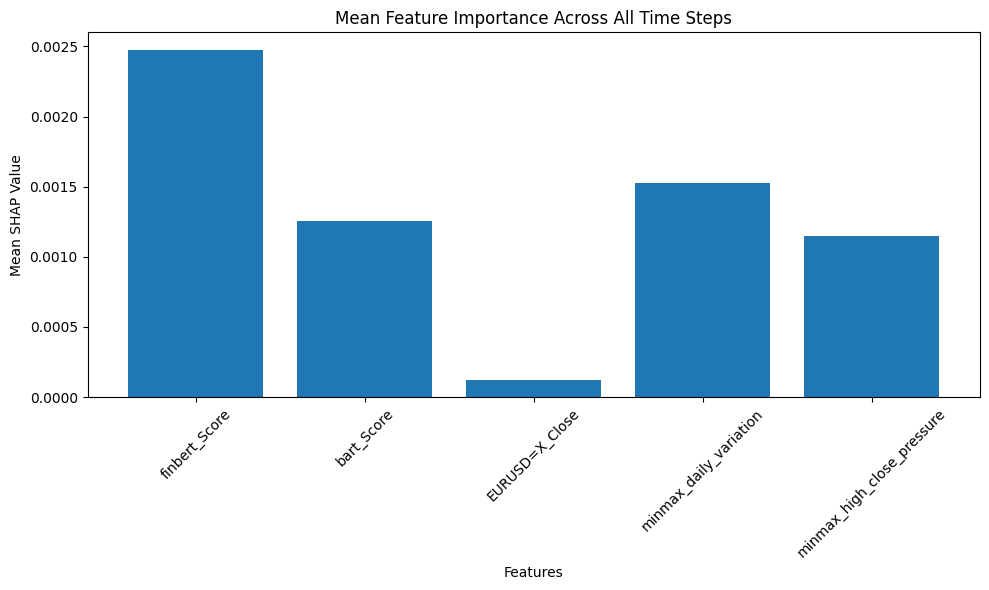

33


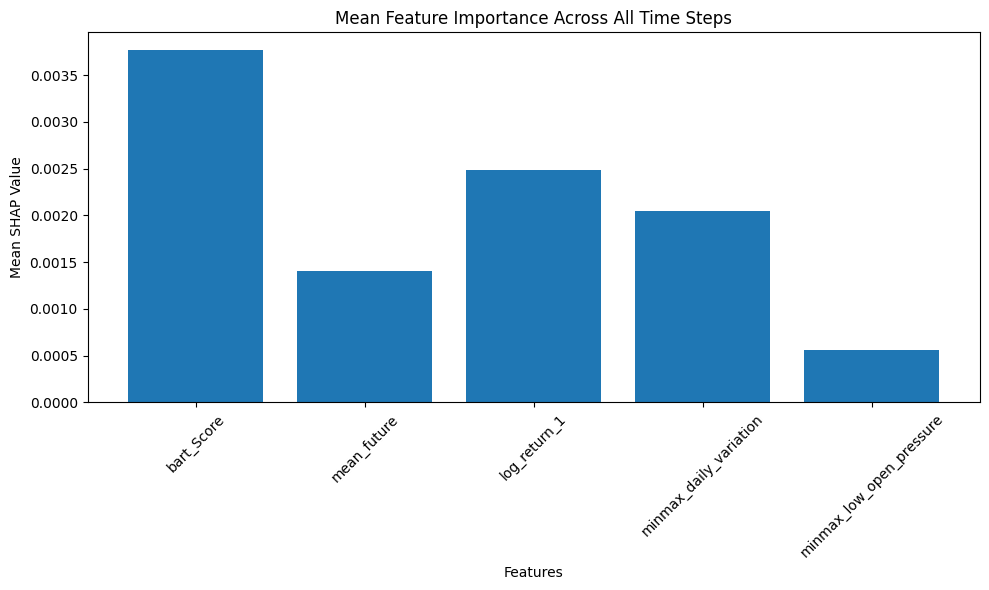

77


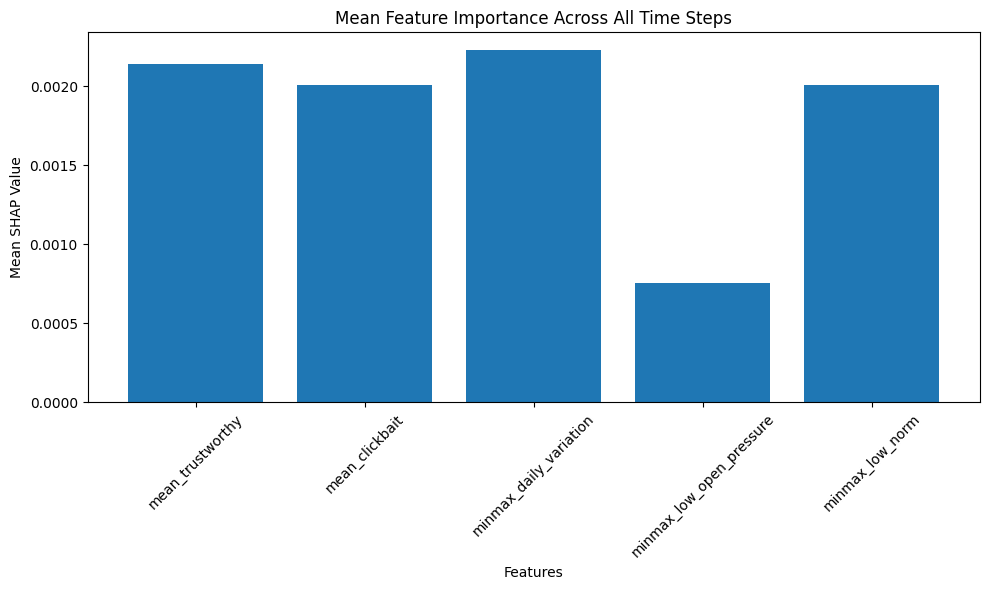

45


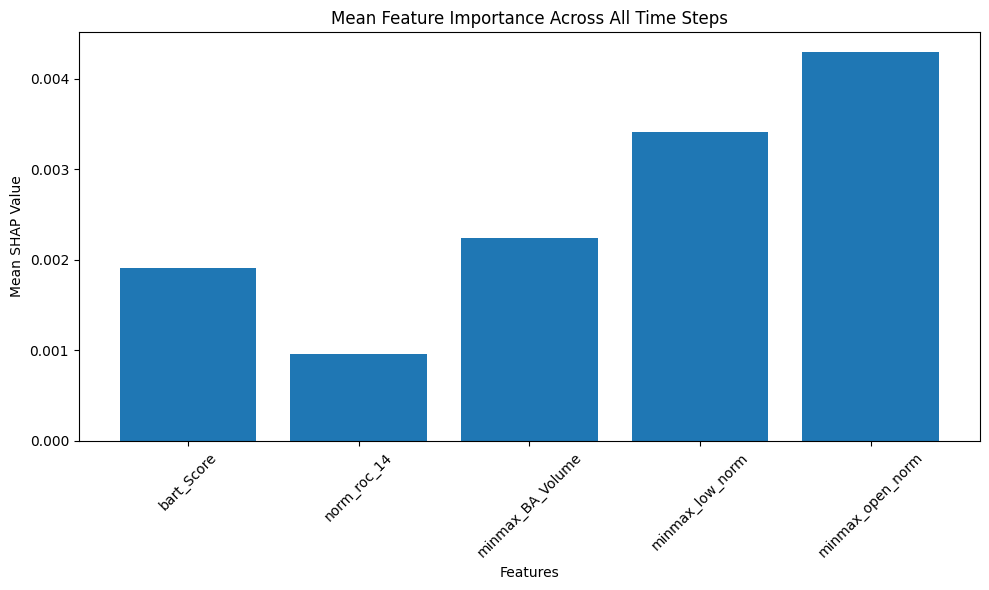

In [45]:
#mean across windows
for index, row in top_10_df.iterrows():
    print(index)
    shap_values = row['aggregated_shap']
    feature_names = row['cols_used']
    plot_mean_feature_importance(shap_values, feature_names)

### Przykładowy model

In [46]:
window_size = 10
target_cols = ['target_5']
cols_used = {'bart_Score',
 'norm_rsi_14',
 'log_return_5',
 'minmax_low_open_pressure',
 'minmax_open_norm'}
X,y = window_dataset(train_set[list(cols_used)+target_cols],  target_cols[0], window_size)
X_val, y_val = window_dataset(val_set[list(cols_used)+target_cols], target_cols[0], window_size)

#model,history = make_model(X,y,100,lstm_units=32)
model, history = make_model_better(X, y, X_val, y_val, n_epochs=200, lstm_units=32,
                              dense_units=8, patience=100)

Train on 646 samples, validate on 30 samples
Epoch 1/200
646/646 [==============================] - 3s 5ms/sample - loss: 0.0060 - val_loss: 0.0019
Epoch 2/200
646/646 [==============================] - 0s 425us/sample - loss: 0.0031 - val_loss: 0.0017
Epoch 3/200
646/646 [==============================] - 0s 439us/sample - loss: 0.0029 - val_loss: 0.0014
Epoch 4/200
646/646 [==============================] - 0s 427us/sample - loss: 0.0030 - val_loss: 0.0014
Epoch 5/200
646/646 [==============================] - 0s 387us/sample - loss: 0.0030 - val_loss: 0.0014
Epoch 6/200
646/646 [==============================] - 0s 381us/sample - loss: 0.0029 - val_loss: 0.0015
Epoch 7/200
646/646 [==============================] - 0s 624us/sample - loss: 0.0028 - val_loss: 0.0013
Epoch 8/200
646/646 [==============================] - 0s 519us/sample - loss: 0.0028 - val_loss: 0.0015
Epoch 9/200
646/646 [==============================] - 0s 518us/sample - loss: 0.0029 - val_loss: 0.0014
Epoch 10/200

#### wyniki

In [47]:
model = load_model('best_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [48]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X)

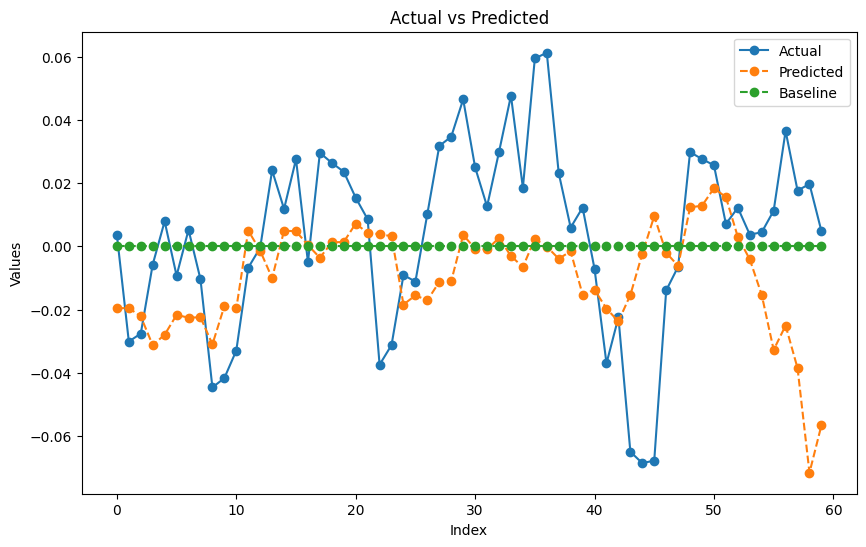

In [49]:
k=-60
plot_actual_vs_predicted(y[k:], y_pred_train[k:], y_base0_train[k:])

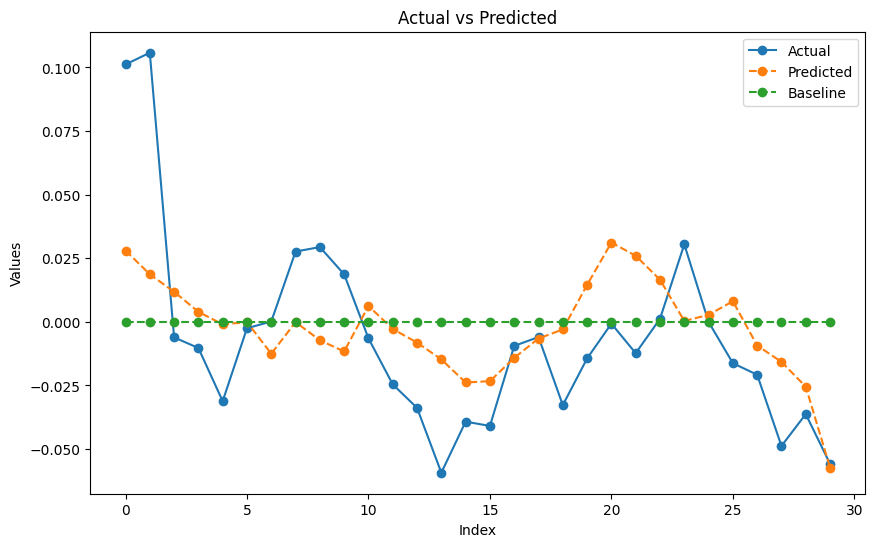

In [50]:
plot_actual_vs_predicted(y_val, y_pred_val, y_base0_val)

In [51]:
print('Model')
print(calculate_metrics(y, y_pred_train, np.array([1]), np.array([1]), y_val, y_pred_val))
print('-----')
print('Baseline 0')
print(calculate_metrics(y, y_base0_train, np.array([1]), np.array([1]), y_val, y_base0_val))
print('-----')
print('Baseline Prev')
print(calculate_metrics(y, y_base_train, np.array([1]), np.array([1]), y_val, y_base_val))


Model
                 MAE       MSE      RMSE  R2 Score         MAPE      MASE
Train       0.033652  0.001944  0.044089  0.318572   295.632777  1.291433
Test        0.000000  0.000000  0.000000       NaN     0.000000  0.000000
Validation  0.024451  0.000957  0.030931  0.313142  1584.531329  0.938321
-----
Baseline 0
                 MAE       MSE      RMSE  R2 Score   MAPE      MASE
Train       0.039650  0.002853  0.053411 -0.000031  100.0  1.521588
Test        0.000000  0.000000  0.000000       NaN    0.0  0.000000
Validation  0.027415  0.001435  0.037876 -0.029927  100.0  1.052056
-----
Baseline Prev
                 MAE       MSE      RMSE  R2 Score         MAPE      MASE
Train       0.058321  0.005983  0.077351 -1.097411   552.156845  2.238101
Test        0.000000  0.000000  0.000000       NaN     0.000000  0.000000
Validation  0.052187  0.004144  0.064371 -1.974836  4423.503320  2.002708


In [52]:
explainer = shap.DeepExplainer(model, X)
shap_values = explainer.shap_values(X_val)

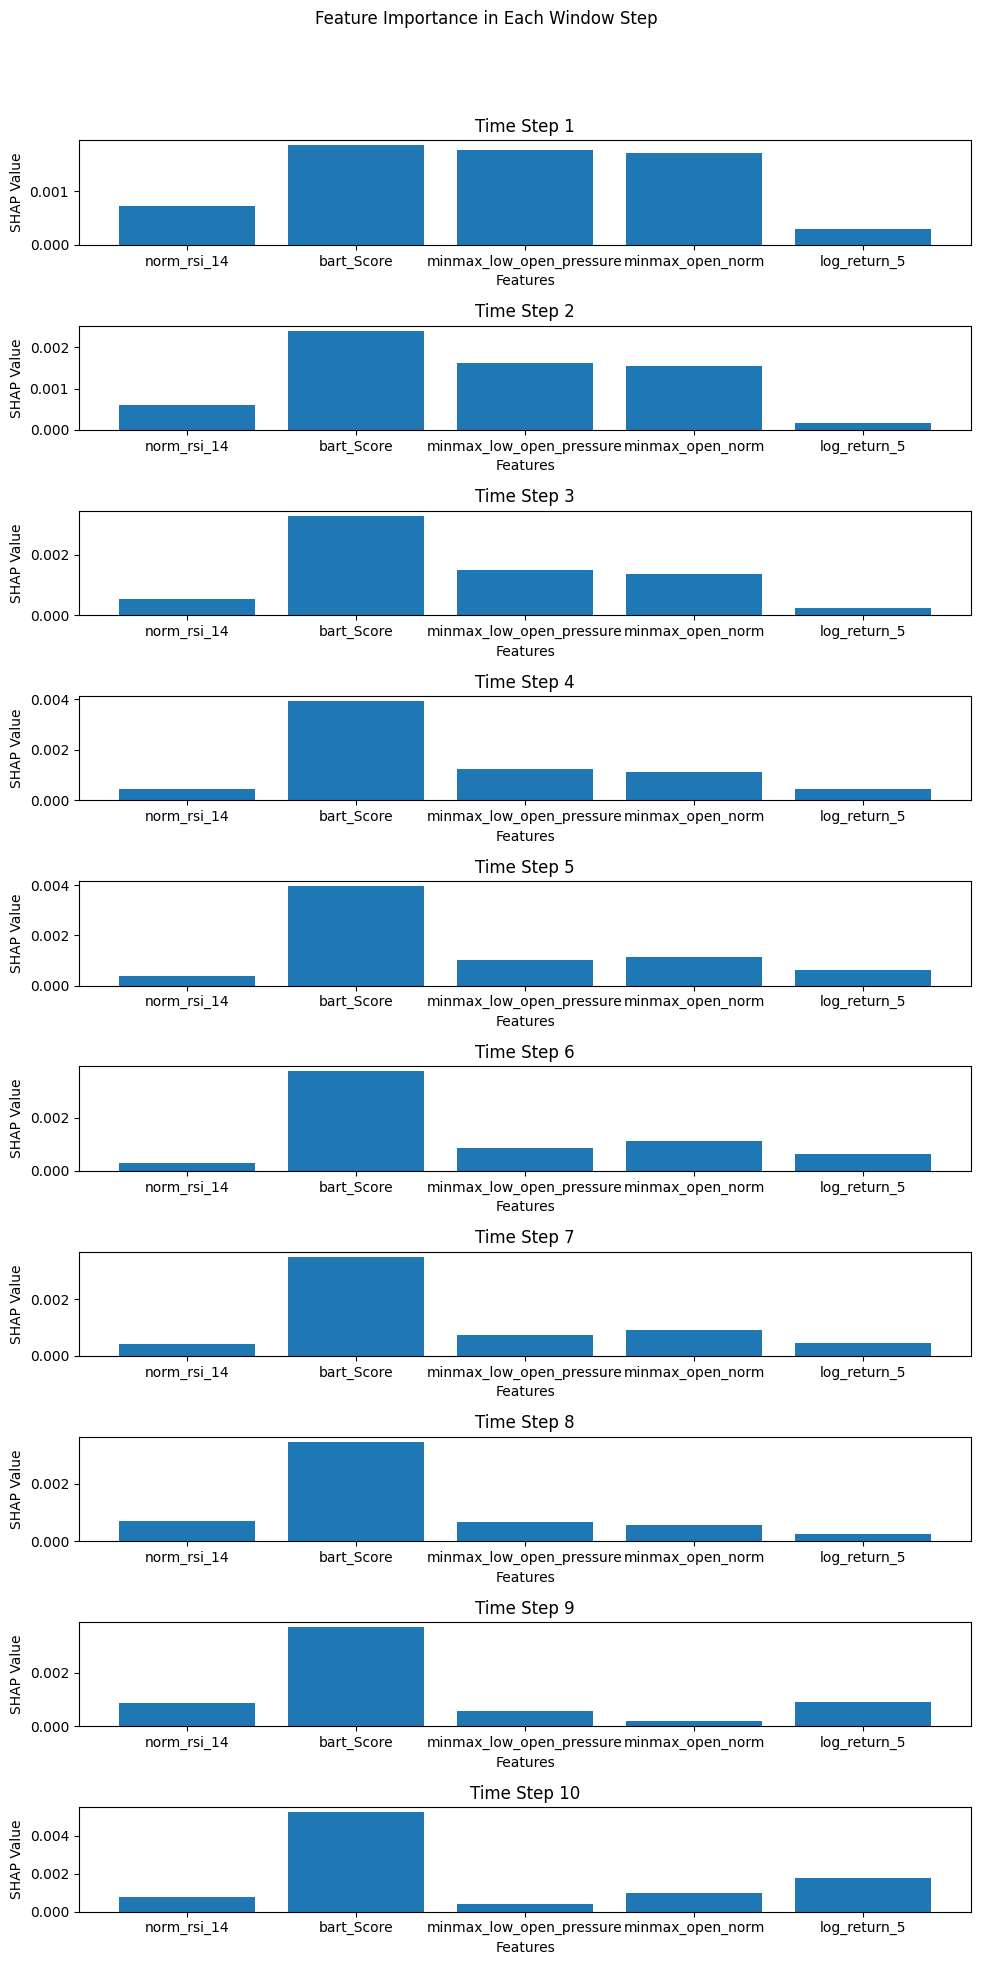

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(shap_values, feature_names,window_size):
    """
    Plot the importance of each feature at each step in the window.

    :param shap_values: A 3D array of SHAP values with shape (samples, window_size, num_features).
    :param feature_names: List of feature names.
    """
    # Aggregate SHAP values across all samples
    aggregated_shap = np.mean(np.abs(shap_values[0]), axis=0)

    # Create a plot for each time step in the window
    window_size = aggregated_shap.shape[0]
    num_features = aggregated_shap.shape[1]

    # Set up the plot
    fig, axs = plt.subplots(window_size, 1, figsize=(10, window_size * 2))
    fig.suptitle('Feature Importance in Each Window Step')

    # Plot each time step
    for i in range(window_size):
        axs[i].bar(feature_names, aggregated_shap[i, :])
        axs[i].set_title(f'Time Step {i+1}')
        axs[i].set_ylabel('SHAP Value')
        axs[i].set_xlabel('Features')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage
feature_names = list(cols_used)
plot_feature_importance(shap_values, feature_names,window_size)
